In [17]:
import os
from pathlib import Path
import joblib
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, Image
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

# -----------------------------
# Phase 1: Config - paths 
# -----------------------------
BASE = Path(r"C:\Users\HOME\Desktop\Data Portfolio\Python Projects\Logistics")
DATA_PROC_DIR = BASE / "Data processing"
FEATURES_DIR = BASE / "Features"
MODELING_DIR = BASE / "Data modeling"
RAW_CSV = Path(r"C:\Users\HOME\Desktop\Data Portfolio\Python Projects\Logistics\Data\logistics.csv")

# For each main folder make summary & images subfolders
for folder in (DATA_PROC_DIR, FEATURES_DIR, MODELING_DIR):
    (folder / "summary").mkdir(parents=True, exist_ok=True)
    (folder / "images").mkdir(parents=True, exist_ok=True)

DATA_PROC_SUM = DATA_PROC_DIR / "summary"
DATA_PROC_IMG = DATA_PROC_DIR / "images"
FEATURES_SUM = FEATURES_DIR / "summary"
FEATURES_IMG = FEATURES_DIR / "images"
MODELING_SUM = MODELING_DIR / "summary"
MODELING_IMG = MODELING_DIR / "images"

# -----------------------------
# Safe Excel writer helper (tries openpyxl then xlsxwriter; falls back to CSVs)
# -----------------------------
def safe_write_excel(path: Path, sheets: dict):
    engines = ["openpyxl", "xlsxwriter"]
    last_exc = None
    for eng in engines:
        try:
            with pd.ExcelWriter(path, engine=eng) as writer:
                for sheet_name, df_ in sheets.items():
                    if isinstance(df_, pd.Series):
                        df_.to_frame(name=sheet_name).to_excel(writer, sheet_name=sheet_name)
                    else:
                        df_.to_excel(writer, sheet_name=sheet_name)
            return True
        except Exception as e:
            last_exc = e
            continue
    # Fallback to CSVs
    for sheet_name, df_ in sheets.items():
        csv_path = path.parent / f"{path.stem}_{sheet_name}.csv"
        if isinstance(df_, pd.Series):
            df_.to_frame(name=sheet_name).to_csv(csv_path, index=True)
        else:
            df_.to_csv(csv_path, index=True)
    print(f"Warning: Could not write Excel file {path}. Wrote CSV fallbacks. Last error: {last_exc}")
    return False

# -----------------------------
# Load original dataset
# -----------------------------
if not RAW_CSV.exists():
    raise FileNotFoundError(f"Data file not found at: {RAW_CSV}")
df = pd.read_csv(RAW_CSV)

# -----------------------------
# Helper: save figure AND display 
# -----------------------------
def save_fig(fig, path):
    """
    Save the matplotlib figure to `path` and display it inline in Jupyter.
    """
    # Ensure parent exists
    Path(path).parent.mkdir(parents=True, exist_ok=True)
    fig.savefig(path, bbox_inches='tight', dpi=150)
    plt.close(fig)
    try:
        display(Image(filename=str(path)))
    except Exception:
        # fallback: print saved path if display fails
        print(f"(Could not display image inline) Saved image to: {path}")



--- Numerical Summary (EDA) ---


,profit_per_order,sales_per_customer,category_id,customer_id,customer_zipcode,department_id,latitude,longitude,order_customer_id,order_id,...,order_item_product_price,order_item_profit_ratio,order_item_quantity,sales,order_item_total_amount,order_profit_per_order,product_card_id,product_category_id,product_price,label
count,15549.000000,15549.000000,15549.000000,15549.000000,15549.000000,15549.000000,15549.000000,15549.000000,15549.000000,15549.000000,...,15549.000000,15549.000000,15549.000000,15549.000000,15549.000000,15549.000000,15549.000000,15549.000000,15549.000000,15549.000000
mean,22.604542,179.888256,31.461342,6583.279789,35458.234968,5.413462,29.677619,-84.512318,6586.810354,35718.970019,...,137.005272,0.120391,2.165202,200.562289,179.780850,22.273342,685.213286,31.387606,136.629368,0.349283
std,99.265198,113.727323,15.303616,4114.273782,37343.702033,1.581550,9.877876,20.681015,4101.324290,21071.742668,...,134.545269,0.474088,1.468627,125.984986,110.999735,117.503163,330.778230,15.256620,133.366285,0.826623
min,-3442.500000,8.351162,2.000000,1.000000,603.000000,2.000000,-33.937553,-158.025990,1.000000,1.000000,...,9.990000,-2.750000,1.000000,9.990000,7.490000,-3442.500000,19.000000,2.000000,9.990000,-1.000000
25%,7.562795,104.397330,18.000000,3119.983200,725.000000,4.000000,18.263327,-98.088170,3177.568800,16530.752000,...,50.000000,0.080000,1.000000,119.980000,105.570910,7.443977,403.000000,18.000000,50.000000,0.000000
50%,31.693370,165.944170,29.000000,6429.229000,19145.775000,5.000000,33.435677,-76.580800,6308.530000,35391.336000,...,59.990000,0.270000,1.000000,199.920000,165.990000,32.440100,627.000000,29.000000,59.990000,1.000000
75%,63.872166,242.440930,45.000000,9642.381000,77502.820000,7.000000,39.277313,-66.370575,9703.070000,55236.910000,...,199.990000,0.360000,3.000000,299.950000,242.436400,64.303566,1004.000000,45.000000,199.990000,1.000000
max,911.800000,1939.990000,76.000000,20757.000000,99205.000000,12.000000,48.781933,115.263080,20757.000000,77204.000000,...,1999.990000,0.500000,5.000000,1999.990000,1939.990000,911.800000,1363.000000,76.000000,1999.990000,1.000000



--- Categorical Summary (EDA) ---


,payment_type,category_name,customer_city,customer_country,customer_segment,customer_state,department_name,market,order_city,order_country,order_date,order_region,order_state,order_status,product_name,shipping_date,shipping_mode
count,15549,15549,15549,15549,15549,15549,15549,15549,15549,15549,15549,15549,15549,15549,15549,15549,15549
unique,4,49,555,2,3,44,11,5,2742,152,1162,23,982,7,113,1170,4
top,DEBIT,Cleats,Caguas,EE. UU.,Consumer,PR,Fan Shop,Europe,Santo Domingo,United States,2017-04-22 00:00:00+01:00,Western Europe,England,COMPLETE,Perfect Fitness Perfect Rip Deck,2015-05-20 00:00:00+01:00,Standard Class
freq,6148,2212,5964,9438,8332,6109,5708,4578,214,2048,43,2513,654,5290,2219,52,9116



--- Missing Values Summary (EDA) ---


,missing_count,missing_percent
payment_type,0,0.0
profit_per_order,0,0.0
sales_per_customer,0,0.0
category_id,0,0.0
category_name,0,0.0
customer_city,0,0.0
customer_country,0,0.0
customer_id,0,0.0
customer_segment,0,0.0
customer_state,0,0.0


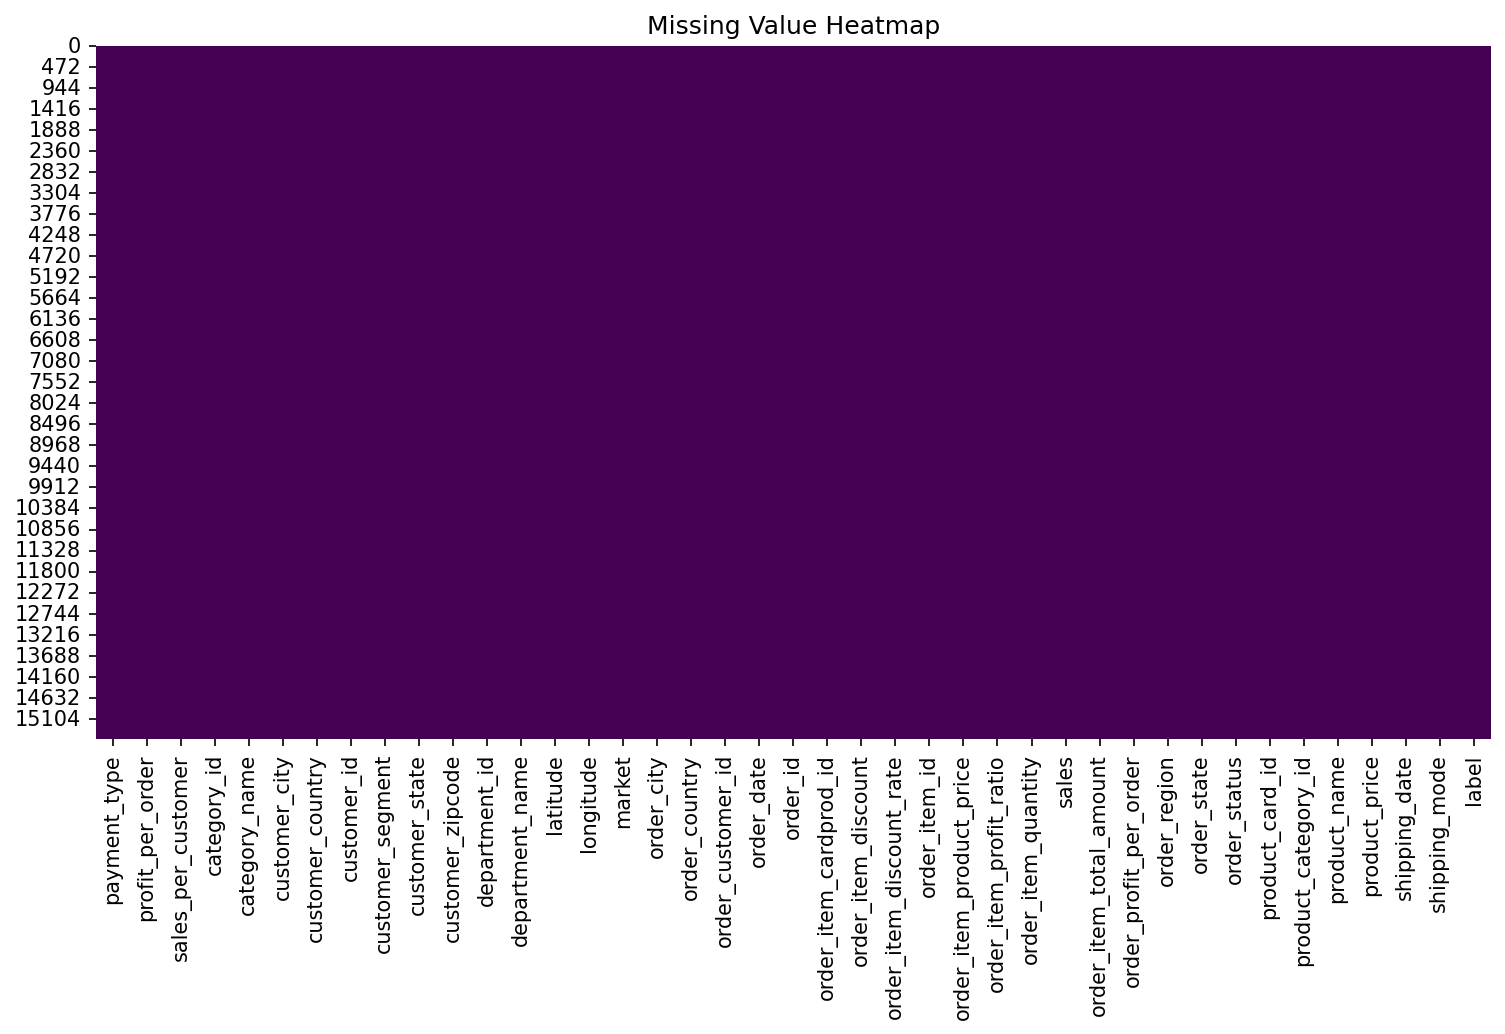

Saved missing_heatmap.png -> C:\Users\HOME\Desktop\Data Portfolio\Python Projects\Logistics\Data processing\images\missing_heatmap.png


C:\Users\HOME\AppData\Local\Temp\ipykernel_16248\459437688.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='label', palette='Set2')


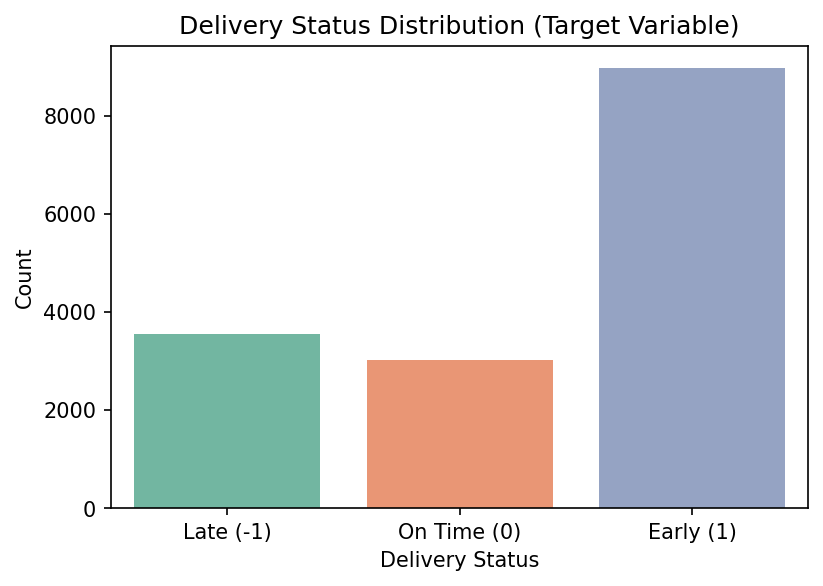

Saved target_distribution.png -> C:\Users\HOME\Desktop\Data Portfolio\Python Projects\Logistics\Data processing\images\target_distribution.png


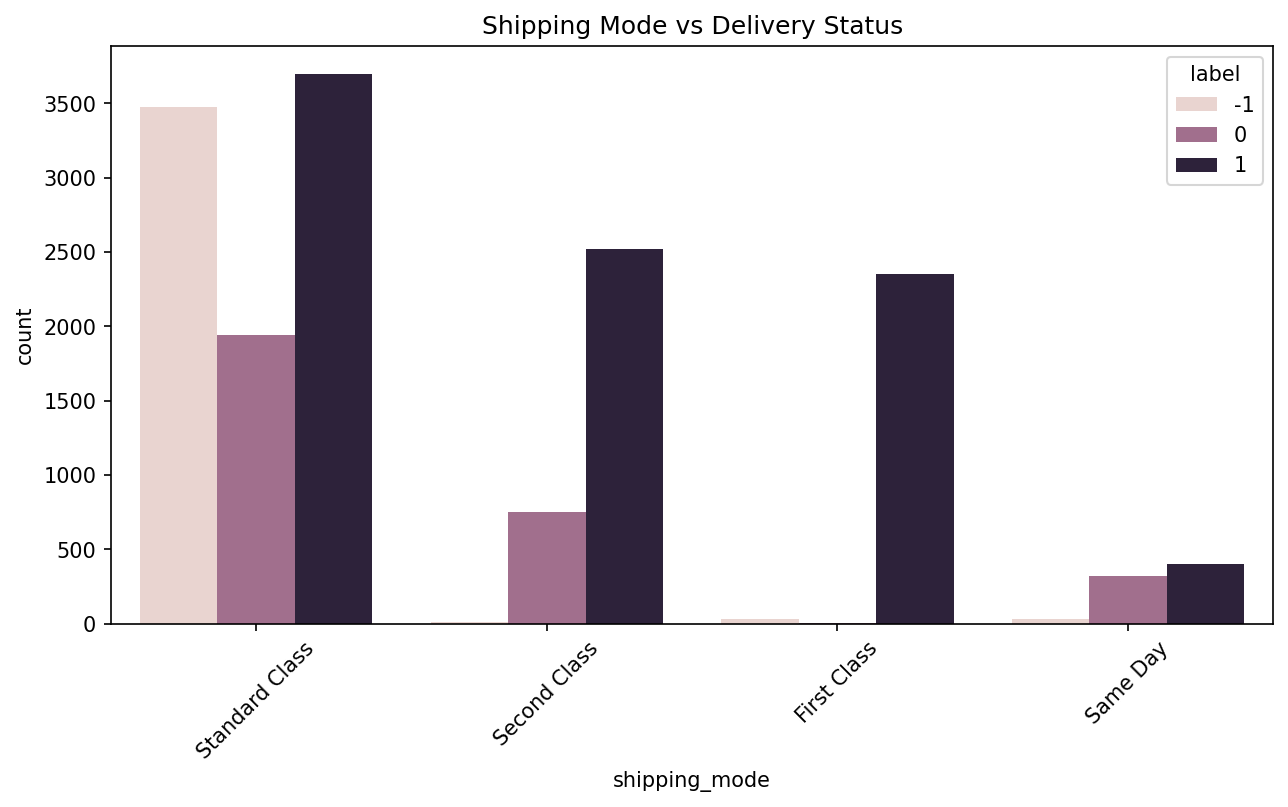

Saved shipping_mode_vs_status.png -> C:\Users\HOME\Desktop\Data Portfolio\Python Projects\Logistics\Data processing\images\shipping_mode_vs_status.png


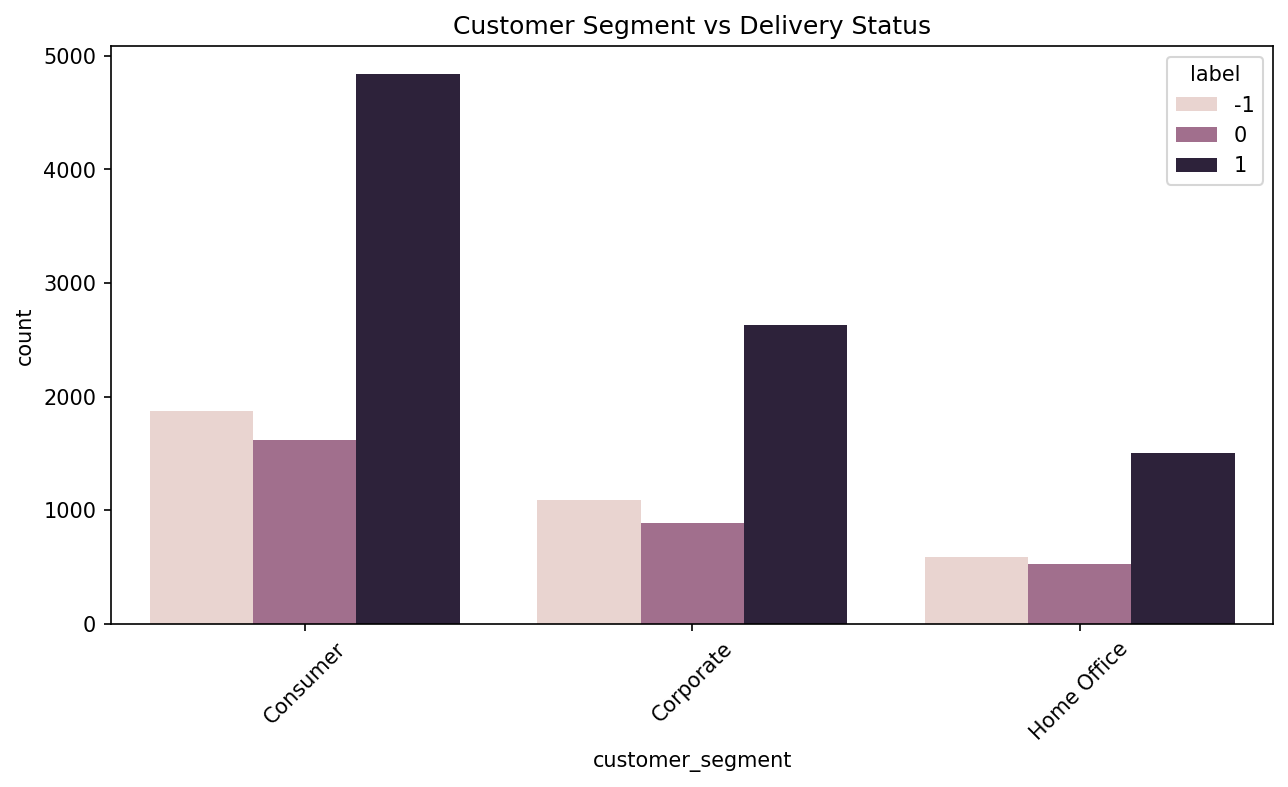

Saved customer_segment_vs_status.png -> C:\Users\HOME\Desktop\Data Portfolio\Python Projects\Logistics\Data processing\images\customer_segment_vs_status.png


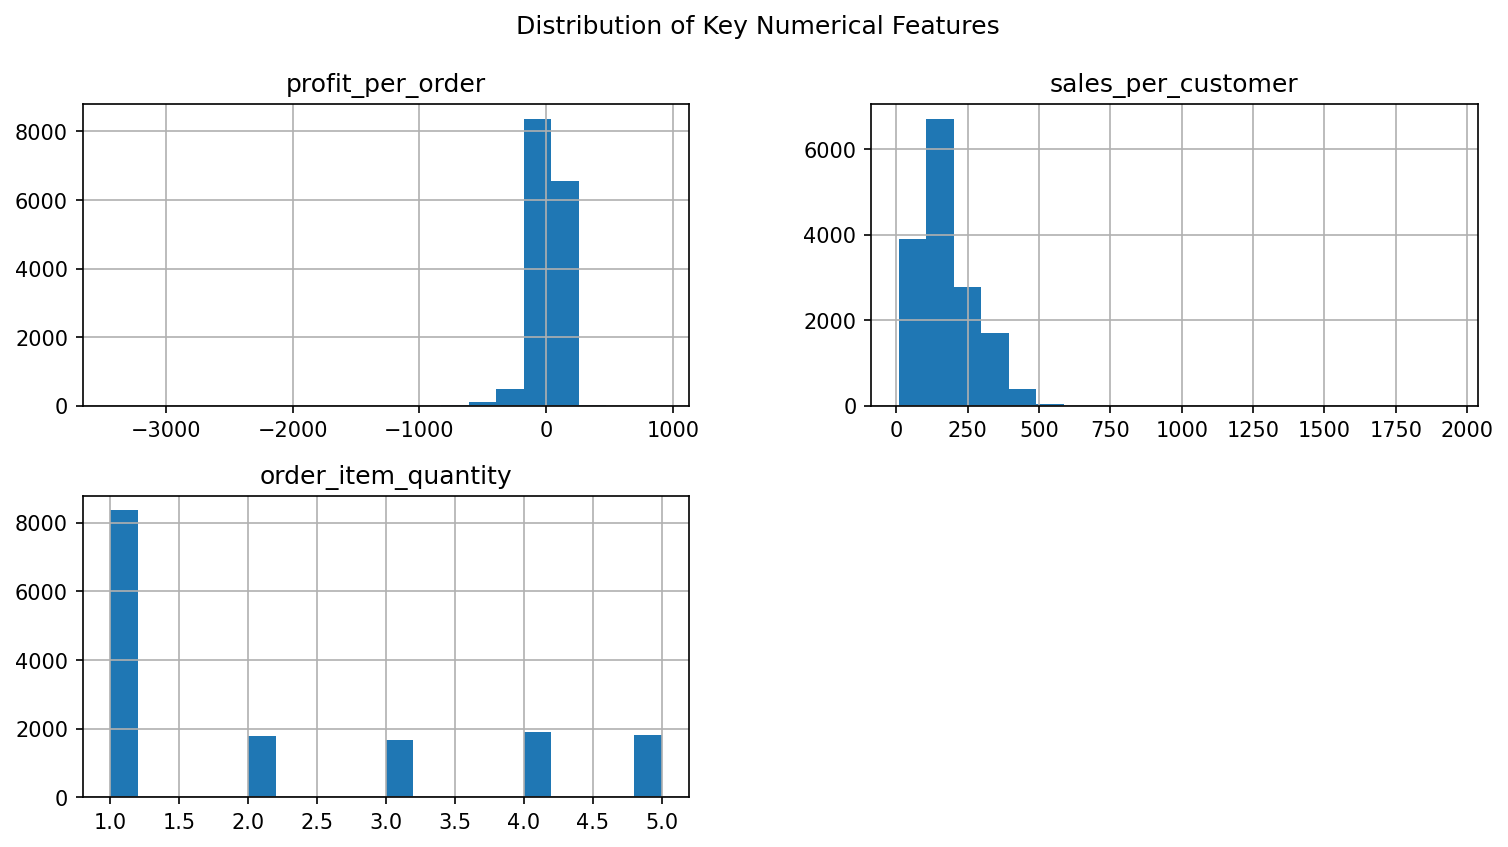

Saved numerical_distributions.png -> C:\Users\HOME\Desktop\Data Portfolio\Python Projects\Logistics\Data processing\images\numerical_distributions.png


In [18]:

# -----------------------------
# Phase 2: EDA (brief) & save summaries + images into Data processing folder
# -----------------------------
numerical_summary = df.describe()
categorical_summary = df.describe(include='object')
missing_counts = df.isnull().sum()
missing_percent = (df.isnull().mean() * 100).round(2)
missing_summary = pd.concat([missing_counts, missing_percent], axis=1)
missing_summary.columns = ['missing_count', 'missing_percent']

eda_excel_path = DATA_PROC_SUM / "eda_descriptive_statistics.xlsx"
safe_write_excel(eda_excel_path, {
    "Numerical": numerical_summary,
    "Categorical": categorical_summary,
    "Missing_Values": missing_summary
})

numerical_summary.to_csv(DATA_PROC_SUM / "numerical_summary.csv")
categorical_summary.to_csv(DATA_PROC_SUM / "categorical_summary.csv")
missing_summary.to_csv(DATA_PROC_SUM / "missing_summary.csv")

# DISPLAY EDA SUMMARIES IN JUPYTER
print("\n--- Numerical Summary (EDA) ---")
display(numerical_summary)
print("\n--- Categorical Summary (EDA) ---")
display(categorical_summary)
print("\n--- Missing Values Summary (EDA) ---")
display(missing_summary)

# 1. Missing heatmap
fig = plt.figure(figsize=(12,6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Value Heatmap")
save_fig(fig, DATA_PROC_IMG / "missing_heatmap.png")
print(f"Saved missing_heatmap.png -> {DATA_PROC_IMG / 'missing_heatmap.png'}")

# 2. Target distribution (if 'label' exists)
if 'label' in df.columns:
    fig = plt.figure(figsize=(6,4))
    sns.countplot(data=df, x='label', palette='Set2')
    plt.title("Delivery Status Distribution (Target Variable)")
    plt.xlabel("Delivery Status"); plt.ylabel("Count")
    try:
        plt.xticks(ticks=[0,1,2], labels=['Late (-1)', 'On Time (0)', 'Early (1)'])
    except Exception:
        pass
    save_fig(fig, DATA_PROC_IMG / "target_distribution.png")
    print(f"Saved target_distribution.png -> {DATA_PROC_IMG / 'target_distribution.png'}")

# 3. shipping_mode vs label
if 'shipping_mode' in df.columns and 'label' in df.columns:
    fig = plt.figure(figsize=(10,5))
    sns.countplot(data=df, x='shipping_mode', hue='label')
    plt.title("Shipping Mode vs Delivery Status")
    plt.xticks(rotation=45)
    save_fig(fig, DATA_PROC_IMG / "shipping_mode_vs_status.png")
    print(f"Saved shipping_mode_vs_status.png -> {DATA_PROC_IMG / 'shipping_mode_vs_status.png'}")

# 4. customer_segment vs label
if 'customer_segment' in df.columns and 'label' in df.columns:
    fig = plt.figure(figsize=(10,5))
    sns.countplot(data=df, x='customer_segment', hue='label')
    plt.title("Customer Segment vs Delivery Status")
    plt.xticks(rotation=45)
    save_fig(fig, DATA_PROC_IMG / "customer_segment_vs_status.png")
    print(f"Saved customer_segment_vs_status.png -> {DATA_PROC_IMG / 'customer_segment_vs_status.png'}")

# 5. Numerical distributions (if columns exist)
num_cols_eda = ['profit_per_order', 'sales_per_customer', 'order_item_quantity']
available_num_eda = [c for c in num_cols_eda if c in df.columns]
if available_num_eda:
    ax = df[available_num_eda].hist(figsize=(12,6), bins=20)
    fig = plt.gcf()
    plt.suptitle("Distribution of Key Numerical Features")
    save_fig(fig, DATA_PROC_IMG / "numerical_distributions.png")
    print(f"Saved numerical_distributions.png -> {DATA_PROC_IMG / 'numerical_distributions.png'}")


In [19]:

# -----------------------------
# Phase 3: Data Preprocessing
# -----------------------------
categorical_cols = [
    'payment_type', 'customer_segment', 'shipping_mode', 'market',
    'customer_country', 'customer_state', 'customer_city',
    'order_country', 'order_state', 'order_city', 'department_name',
    'category_name', 'order_region', 'product_name', 'order_status'
]

categorical_present = [c for c in categorical_cols if c in df.columns]
label_encoders = {}
for col in categorical_present:
    le = LabelEncoder()
    df[col] = df[col].astype(str)
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

joblib.dump(label_encoders, DATA_PROC_SUM / "label_encoders.joblib")

numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
pre_impute_missing = df.isnull().sum()
df[numerical_cols] = df[numerical_cols].fillna(df[numerical_cols].median())

object_cols = df.select_dtypes(include=['object']).columns.tolist()
for col in object_cols:
    if df[col].isnull().any():
        try:
            df[col] = df[col].fillna(df[col].mode()[0])
        except Exception:
            df[col] = df[col].fillna('missing')

post_impute_missing = df.isnull().sum()
missing_impute_df = pd.concat(
    [pre_impute_missing.rename('pre_impute'), post_impute_missing.rename('post_impute')], axis=1
)
missing_impute_df.to_csv(DATA_PROC_SUM / "missing_before_after_imputation.csv")

# DISPLAY IMPUTATION SUMMARY IN JUPYTER
print("\n--- Missing Values: before and after imputation ---")
display(missing_impute_df)

scaler = MinMaxScaler()
features_to_scale = [
    'profit_per_order', 'sales_per_customer',
    'order_item_discount', 'order_item_quantity',
    'order_item_product_price', 'order_item_total_amount'
]
features_present = [c for c in features_to_scale if c in df.columns]
if features_present:
    df[features_present] = scaler.fit_transform(df[features_present])
    joblib.dump(scaler, DATA_PROC_SUM / "minmax_scaler.joblib")

preprocessed_csv = DATA_PROC_DIR / "logistics_preprocessed.csv"
df.to_csv(preprocessed_csv, index=False)

# Also save and DISPLAY a quick summary of the preprocessed dataset
df.describe().to_csv(DATA_PROC_SUM / "preprocessed_numerical_summary.csv")
df.describe(include='object').to_csv(DATA_PROC_SUM / "preprocessed_categorical_summary.csv")
print("\n--- Preprocessed Numerical Summary ---")
display(df.describe())
print("\n--- Preprocessed Categorical Summary ---")
display(df.describe(include='object'))



--- Missing Values: before and after imputation ---


,pre_impute,post_impute
payment_type,0,0
profit_per_order,0,0
sales_per_customer,0,0
category_id,0,0
category_name,0,0
customer_city,0,0
customer_country,0,0
customer_id,0,0
customer_segment,0,0
customer_state,0,0



--- Preprocessed Numerical Summary ---


,payment_type,profit_per_order,sales_per_customer,category_id,category_name,customer_city,customer_country,customer_id,customer_segment,customer_state,...,order_profit_per_order,order_region,order_state,order_status,product_card_id,product_category_id,product_name,product_price,shipping_mode,label
count,15549.000000,15549.000000,15549.000000,15549.000000,15549.000000,15549.000000,15549.000000,15549.000000,15549.000000,15549.000000,...,15549.000000,15549.000000,15549.000000,15549.000000,15549.000000,15549.000000,15549.000000,15549.000000,15549.000000,15549.000000
mean,1.622870,0.795789,0.088804,31.461342,26.554698,188.266898,0.393016,6583.279789,0.632259,24.408258,...,22.273342,12.239501,489.241237,2.933565,685.213286,31.387606,55.658499,136.629368,2.229918,0.349283
std,0.974214,0.022797,0.058876,15.303616,13.807398,158.455948,0.488436,4114.273782,0.754169,12.934281,...,117.503163,7.034929,271.637078,2.170450,330.778230,15.256620,22.059557,133.366285,1.094254,0.826623
min,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,-3442.500000,0.000000,0.000000,0.000000,19.000000,2.000000,0.000000,9.990000,0.000000,-1.000000
25%,1.000000,0.792335,0.049723,18.000000,12.000000,64.000000,0.000000,3119.983200,0.000000,13.000000,...,7.443977,6.000000,280.000000,1.000000,403.000000,18.000000,52.000000,50.000000,2.000000,0.000000
50%,1.000000,0.797876,0.081585,29.000000,29.000000,88.000000,0.000000,6429.229000,0.000000,33.000000,...,32.440100,12.000000,492.000000,2.000000,627.000000,29.000000,57.000000,59.990000,3.000000,1.000000
75%,2.000000,0.805267,0.121187,45.000000,37.000000,309.000000,1.000000,9642.381000,1.000000,34.000000,...,64.303566,19.000000,727.000000,5.000000,1004.000000,45.000000,67.000000,199.990000,3.000000,1.000000
max,3.000000,1.000000,1.000000,76.000000,48.000000,554.000000,1.000000,20757.000000,2.000000,43.000000,...,911.800000,22.000000,981.000000,6.000000,1363.000000,76.000000,112.000000,1999.990000,3.000000,1.000000



--- Preprocessed Categorical Summary ---


,order_date,shipping_date
count,15549,15549
unique,1162,1170
top,2017-04-22 00:00:00+01:00,2015-05-20 00:00:00+01:00
freq,43,52


C:\Users\HOME\AppData\Local\Temp\ipykernel_16248\3832198126.py:9: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df[date_col] = pd.to_datetime(df[date_col], errors='coerce', infer_datetime_format=True)
C:\Users\HOME\AppData\Local\Temp\ipykernel_16248\3832198126.py:9: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df[date_col] = pd.to_datetime(df[date_col], errors='coerce', infer_datetime_format=True)
C:\Users\HOME\AppData\Local\Temp\ipykernel_16248\3832198126.py:9: UserWarning: The argument 'infer_date


--- Feature Engineering Summary ---


rows_after_date_processing                                                15549
dropped_rows_due_to_dates                                                     0
shipping_duration_stats       {'count': 15549.0, 'mean': 10.954016335455655,...
dtype: object


--- Engineered Data Head ---


,payment_type,profit_per_order,sales_per_customer,category_id,category_name,customer_city,customer_country,customer_segment,customer_state,customer_zipcode,...,order_status,product_category_id,product_name,product_price,shipping_date,shipping_mode,label,shipping_duration,high_volume_customer,high_profit_margin
0,1,0.798509,0.043559,9.0,10,64,1,0,34,725.0000,...,1,9.0,57,99.99,2015-08-13 00:00:00+01:00,3,-1,1.0,0,1
1,3,0.811541,0.089892,48.0,45,3,0,0,3,92745.1600,...,4,48.0,66,199.99,2017-04-09 00:00:00+01:00,3,-1,11.0,0,1
2,1,0.792507,0.042252,46.0,29,8,1,0,34,2457.7297,...,1,46.0,63,49.98,NaT,2,1,11.0,0,0
3,3,0.770052,0.047006,17.0,12,64,1,0,34,725.0000,...,6,17.0,67,59.99,NaT,2,0,11.0,0,0
4,1,0.800869,0.084191,48.0,45,380,0,0,3,95118.6000,...,1,48.0,66,199.99,2015-03-30 00:00:00+01:00,3,1,11.0,0,0


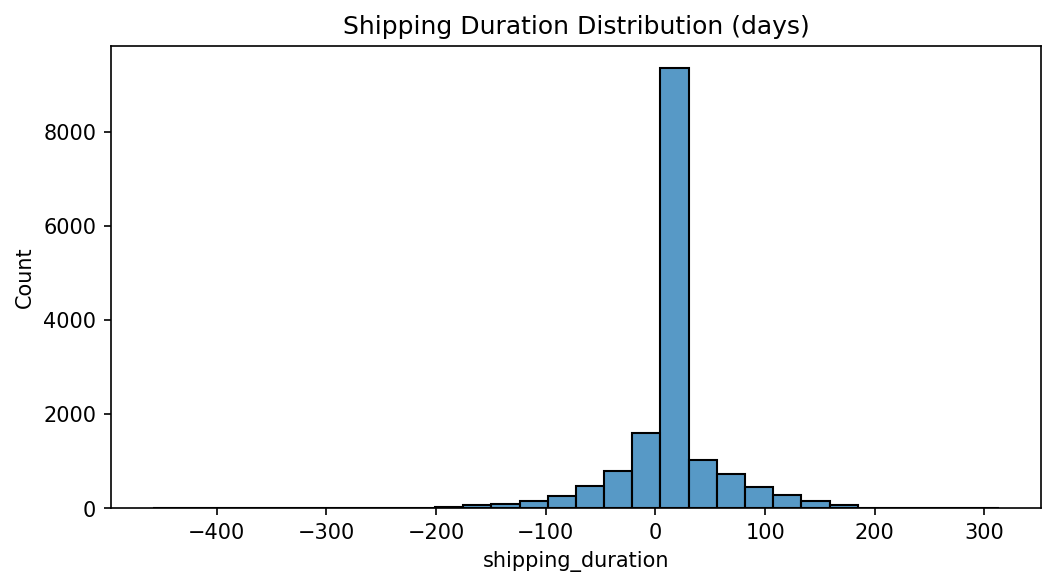

Saved shipping_duration_distribution.png -> C:\Users\HOME\Desktop\Data Portfolio\Python Projects\Logistics\Features\images\shipping_duration_distribution.png


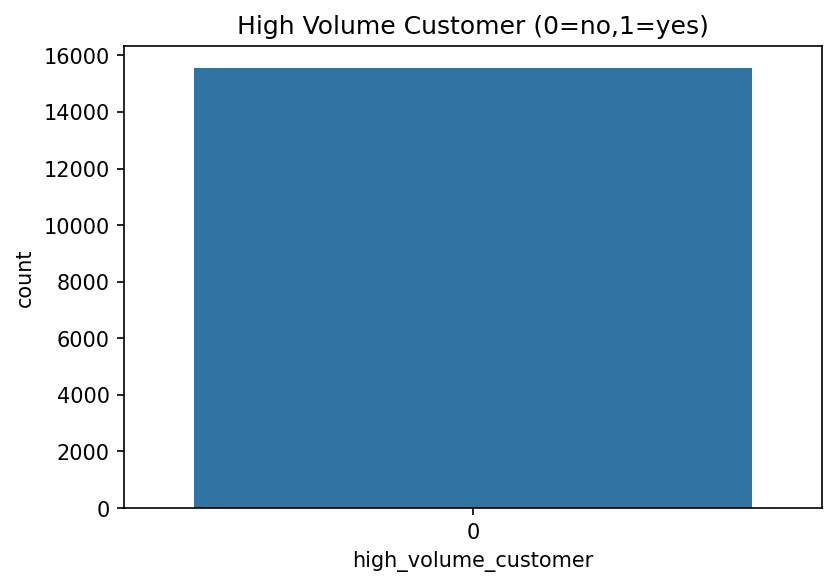

Saved high_volume_customer_counts.png -> C:\Users\HOME\Desktop\Data Portfolio\Python Projects\Logistics\Features\images\high_volume_customer_counts.png


In [20]:

# -----------------------------
# Phase 4: Feature Engineering (fixed datetime handling)
# -----------------------------
df = pd.read_csv(preprocessed_csv)

# Robust datetime conversion: convert explicitly and coerce invalid values to NaT
for date_col in ['order_date', 'shipping_date']:
    if date_col in df.columns:
        df[date_col] = pd.to_datetime(df[date_col], errors='coerce', infer_datetime_format=True)

# Compute shipping_duration robustly
if 'order_date' in df.columns and 'shipping_date' in df.columns:
    if not np.issubdtype(df['order_date'].dtype, np.datetime64):
        df['order_date'] = pd.to_datetime(df['order_date'], errors='coerce', infer_datetime_format=True)
    if not np.issubdtype(df['shipping_date'].dtype, np.datetime64):
        df['shipping_date'] = pd.to_datetime(df['shipping_date'], errors='coerce', infer_datetime_format=True)

    df['shipping_duration'] = (df['shipping_date'] - df['order_date']).dt.days

    if df['shipping_duration'].notna().any():
        median_sd = int(df['shipping_duration'].median())
        df['shipping_duration'] = df['shipping_duration'].fillna(median_sd)
    else:
        df['shipping_duration'] = df['shipping_duration'].astype(float)
    dropped = 0
else:
    df['shipping_duration'] = np.nan
    dropped = 0

# 2. High-volume customer
if 'customer_id' in df.columns:
    customer_order_counts = df['customer_id'].value_counts()
    df['high_volume_customer'] = df['customer_id'].map(lambda x: 1 if customer_order_counts.get(x, 0) > 10 else 0)
else:
    df['high_volume_customer'] = 0

# 3. High profit margin flag
if 'order_item_profit_ratio' in df.columns:
    df['high_profit_margin'] = df['order_item_profit_ratio'].apply(lambda x: 1 if x > 0.3 else 0)
else:
    df['high_profit_margin'] = 0

# 4. Drop redundant / high-cardinality ids if present
drop_cols = ['order_id', 'order_item_id', 'customer_id', 'product_card_id', 'order_item_cardprod_id']
for c in drop_cols:
    if c in df.columns:
        df.drop(columns=[c], inplace=True)

# Save engineered dataset
engineered_csv = FEATURES_DIR / "logistics_engineered.csv"
df.to_csv(engineered_csv, index=False)

fe_summary = {
    "rows_after_date_processing": len(df),
    "dropped_rows_due_to_dates": dropped,
    "shipping_duration_stats": df['shipping_duration'].describe().to_dict() if 'shipping_duration' in df.columns else {}
}
pd.Series(fe_summary).to_csv(FEATURES_SUM / "feature_engineering_summary.csv")

# DISPLAY FEATURE ENGINEERING SUMMARY & HEAD
print("\n--- Feature Engineering Summary ---")
display(pd.Series(fe_summary))
print("\n--- Engineered Data Head ---")
display(df.head())

# Save feature-engineering images
if 'shipping_duration' in df.columns and df['shipping_duration'].notnull().any():
    fig = plt.figure(figsize=(8,4))
    sns.histplot(df['shipping_duration'].dropna(), bins=30)
    plt.title("Shipping Duration Distribution (days)")
    save_fig(fig, FEATURES_IMG / "shipping_duration_distribution.png")
    print(f"Saved shipping_duration_distribution.png -> {FEATURES_IMG / 'shipping_duration_distribution.png'}")

if 'high_volume_customer' in df.columns:
    fig = plt.figure(figsize=(6,4))
    sns.countplot(x='high_volume_customer', data=df)
    plt.title("High Volume Customer (0=no,1=yes)")
    save_fig(fig, FEATURES_IMG / "high_volume_customer_counts.png")
    print(f"Saved high_volume_customer_counts.png -> {FEATURES_IMG / 'high_volume_customer_counts.png'}")

df.head().to_csv(FEATURES_SUM / "engineered_head.csv", index=False)



C:\Users\HOME\anaconda\envs\geophy\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



--- Classification Report: Logistic Regression ---
              precision    recall  f1-score   support

          -1     0.0000    0.0000    0.0000       709
           0     1.0000    0.0017    0.0033       606
           1     0.5775    1.0000    0.7322      1795

    accuracy                         0.5775      3110
   macro avg     0.5258    0.3339    0.2452      3110
weighted avg     0.5282    0.5775    0.4232      3110



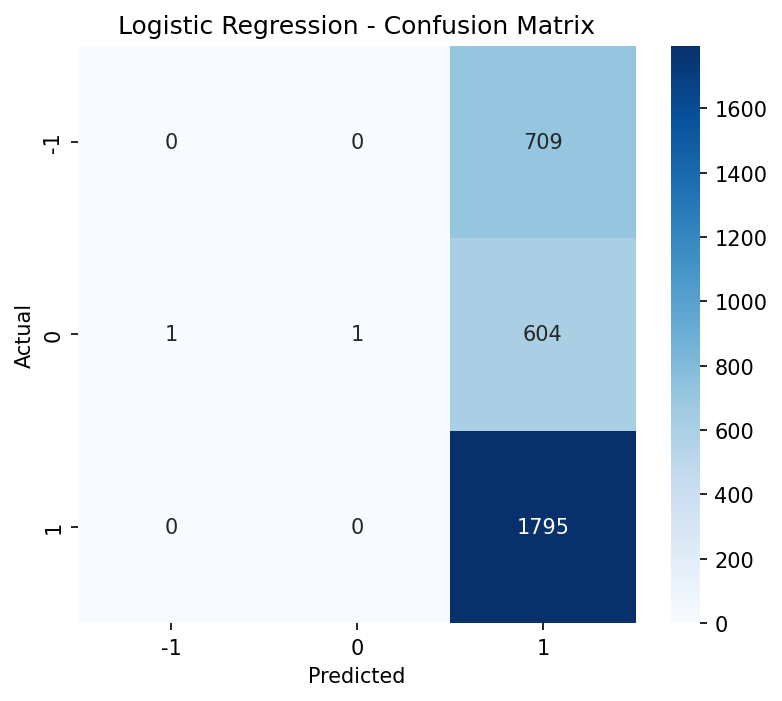

Saved Logistic Regression confusion matrix -> C:\Users\HOME\Desktop\Data Portfolio\Python Projects\Logistics\Data modeling\images\Logistic_Regression_confusion_matrix.png

--- Classification Report: Random Forest ---
              precision    recall  f1-score   support

          -1     0.4048    0.4260    0.4151       709
           0     0.2400    0.0198    0.0366       606
           1     0.6396    0.8245    0.7204      1795

    accuracy                         0.5768      3110
   macro avg     0.4281    0.4234    0.3907      3110
weighted avg     0.5082    0.5768    0.5175      3110



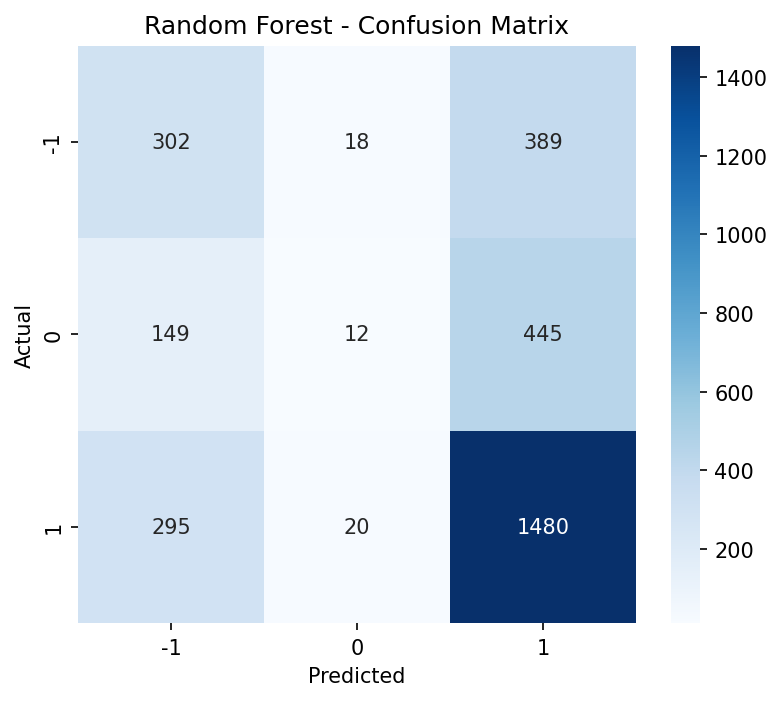

Saved Random Forest confusion matrix -> C:\Users\HOME\Desktop\Data Portfolio\Python Projects\Logistics\Data modeling\images\Random_Forest_confusion_matrix.png

--- Classification Report: XGBoost ---
              precision    recall  f1-score   support

          -1     0.3900    0.4175    0.4033       709
           0     0.3204    0.0957    0.1474       606
           1     0.6475    0.7827    0.7087      1795

    accuracy                         0.5656      3110
   macro avg     0.4526    0.4320    0.4198      3110
weighted avg     0.5250    0.5656    0.5297      3110



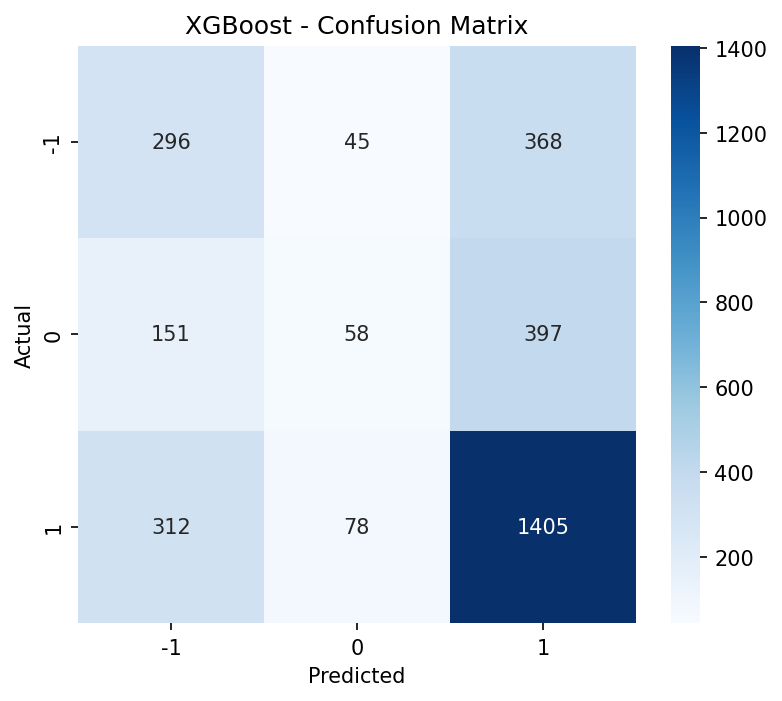

Saved XGBoost confusion matrix -> C:\Users\HOME\Desktop\Data Portfolio\Python Projects\Logistics\Data modeling\images\XGBoost_confusion_matrix.png

--- Model Performance Comparison ---


,Accuracy,F1 Score
XGBoost,0.565595,0.529697
Random Forest,0.576849,0.517542
Logistic Regression,0.577492,0.423249


In [21]:
# -----------------------------
# Phase 5: Model Development
# -----------------------------
df = pd.read_csv(engineered_csv)

non_numeric_cols = df.select_dtypes(exclude=[np.number, 'bool']).columns.tolist()

cols_to_drop = ['order_date', 'shipping_date']
cols_to_drop = cols_to_drop + [c for c in non_numeric_cols if c != 'label']
cols_to_drop = list(dict.fromkeys(cols_to_drop))

X = df.drop(columns=cols_to_drop + (['label'] if 'label' in df.columns else []), errors='ignore')
y = df['label'] if 'label' in df.columns else None

if y is None:
    raise ValueError("Target column 'label' not found in engineered dataset.")

label_encoder_y = LabelEncoder()
y_encoded = label_encoder_y.fit_transform(y)
joblib.dump(label_encoder_y, MODELING_SUM / "label_encoder_y.joblib")

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42, verbosity=0)
}

trained_models = {}
results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    trained_models[name] = model

    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)
    f1 = f1_score(y_test, preds, average='weighted')
    results[name] = {'Accuracy': acc, 'F1 Score': f1}

    decoded_preds = label_encoder_y.inverse_transform(preds)
    decoded_y_test = label_encoder_y.inverse_transform(y_test)

    creport = classification_report(decoded_y_test, decoded_preds, digits=4)
    with open(MODELING_SUM / f"{name.replace(' ', '_')}_classification_report.txt", "w", encoding="utf-8") as f:
        f.write(creport)

    # DISPLAY classification report in Jupyter
    print(f"\n--- Classification Report: {name} ---")
    print(creport)

    cm = confusion_matrix(decoded_y_test, decoded_preds)
    fig = plt.figure(figsize=(6,5))
    classes = label_encoder_y.classes_.tolist()
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")

    # save & print using a safe fname to avoid nested f-string issues
    fname = f"{name.replace(' ', '_')}_confusion_matrix.png"
    save_fig(fig, MODELING_IMG / fname)
    print(f"Saved {name} confusion matrix -> {MODELING_IMG / fname}")

    joblib.dump(model, MODELING_SUM / f"{name.replace(' ', '_')}.joblib")

# Save and DISPLAY model comparison table
comparison_df = pd.DataFrame(results).T.sort_values(by='F1 Score', ascending=False)
comparison_df.to_csv(MODELING_SUM / "model_performance_comparison.csv")
safe_write_excel(MODELING_SUM / "model_performance_comparison.xlsx", {"Model Comparison": comparison_df})

print("\n--- Model Performance Comparison ---")
display(comparison_df)


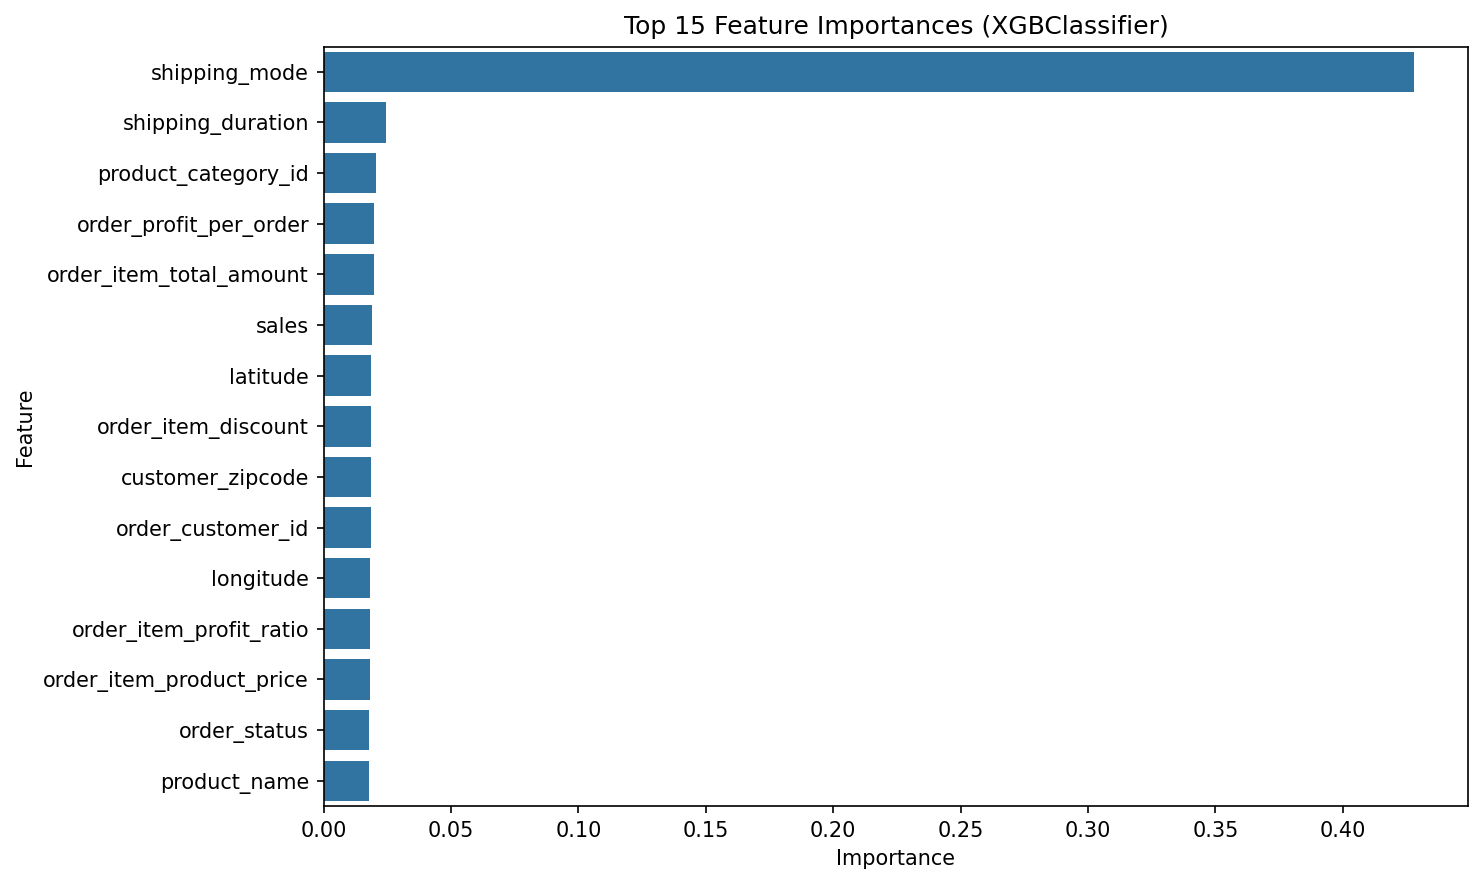

Saved top_feature_importances.png -> C:\Users\HOME\Desktop\Data Portfolio\Python Projects\Logistics\Features\images\top_feature_importances.png

--- Top Feature Importances ---


,Feature,Importance
32,shipping_mode,0.427784
33,shipping_duration,0.024567
29,product_category_id,0.020709
25,order_profit_per_order,0.019756
24,order_item_total_amount,0.019628
23,sales,0.019003
12,latitude,0.018625
18,order_item_discount,0.018545
9,customer_zipcode,0.018456
17,order_customer_id,0.018446



✅ Pipeline finished.
Data processing summaries -> C:\Users\HOME\Desktop\Data Portfolio\Python Projects\Logistics\Data processing\summary
Data processing images    -> C:\Users\HOME\Desktop\Data Portfolio\Python Projects\Logistics\Data processing\images
Features summaries        -> C:\Users\HOME\Desktop\Data Portfolio\Python Projects\Logistics\Features\summary
Features images           -> C:\Users\HOME\Desktop\Data Portfolio\Python Projects\Logistics\Features\images
Modeling summaries        -> C:\Users\HOME\Desktop\Data Portfolio\Python Projects\Logistics\Data modeling\summary
Modeling images           -> C:\Users\HOME\Desktop\Data Portfolio\Python Projects\Logistics\Data modeling\images


In [22]:

# -----------------------------
# Phase 6: Feature Importance & Recommendations
# -----------------------------
best_model = None
if "XGBoost" in trained_models:
    best_model = trained_models["XGBoost"]
elif "Random Forest" in trained_models:
    best_model = trained_models["Random Forest"]
elif "Logistic Regression" in trained_models:
    best_model = trained_models["Logistic Regression"]

if best_model is not None and hasattr(best_model, "feature_importances_"):
    importances = best_model.feature_importances_
    features = X.columns.tolist()
    feature_importance_df = pd.DataFrame({
        'Feature': features,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)

    feature_importance_df.to_csv(FEATURES_SUM / "feature_importances_all.csv", index=False)
    safe_write_excel(FEATURES_SUM / "feature_importances.xlsx", {"Feature Importances": feature_importance_df})

    top_n = min(15, len(feature_importance_df))
    fig = plt.figure(figsize=(10, 6))
    sns.barplot(data=feature_importance_df.head(top_n), x='Importance', y='Feature')
    plt.title(f"Top {top_n} Feature Importances ({best_model.__class__.__name__})")
    plt.tight_layout()
    save_fig(fig, FEATURES_IMG / "top_feature_importances.png")
    print(f"Saved top_feature_importances.png -> {FEATURES_IMG / 'top_feature_importances.png'}")

    feature_importance_df.head(top_n).to_csv(FEATURES_SUM / "top_feature_importances.csv", index=False)

    # DISPLAY feature importance table in Jupyter
    print("\n--- Top Feature Importances ---")
    display(feature_importance_df.head(top_n))
else:
    if best_model is not None and hasattr(best_model, "coef_"):
        coef = np.abs(best_model.coef_).mean(axis=0) if best_model.coef_.ndim > 1 else np.abs(best_model.coef_)
        features = X.columns.tolist()
        feature_importance_df = pd.DataFrame({
            'Feature': features,
            'Importance': coef
        }).sort_values(by='Importance', ascending=False)
        feature_importance_df.to_csv(FEATURES_SUM / "feature_importances_coef.csv", index=False)
        fig = plt.figure(figsize=(10,6))
        sns.barplot(data=feature_importance_df.head(15), x='Importance', y='Feature')
        plt.title("Top 15 Coefficient Importances")
        save_fig(fig, FEATURES_IMG / "top_coef_importances.png")
        print(f"Saved top_coef_importances.png -> {FEATURES_IMG / 'top_coef_importances.png'}")

        print("\n--- Top Coefficient Importances ---")
        display(feature_importance_df.head(15))
    else:
        with open(FEATURES_SUM / "feature_importance_note.txt", "w", encoding="utf-8") as f:
            f.write("No feature importance available from trained models.")
        print("\nNo feature importance available from trained models. See feature_importance_note.txt")

# -----------------------------
# Final confirmations (prints)
# -----------------------------
print("\n✅ Pipeline finished.")
print(f"Data processing summaries -> {DATA_PROC_SUM}")
print(f"Data processing images    -> {DATA_PROC_IMG}")
print(f"Features summaries        -> {FEATURES_SUM}")
print(f"Features images           -> {FEATURES_IMG}")
print(f"Modeling summaries        -> {MODELING_SUM}")
print(f"Modeling images           -> {MODELING_IMG}")
